In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import wikipedia
import warnings
import random

from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz

# 0 Utility

In [98]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [99]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Final

In [115]:
df_music5 = pd.read_csv('../music_data/dataset-12-5.csv')

In [116]:
df_music5.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Genre
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180,9877,52,easyListening
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,59717,59,country
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,120725,63,pop
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,120725,63,pop
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,120725,63,pop


In [102]:
do_log(df_music5,feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount', 'Followers'])
z_score_norm(df_music5, feature_list=['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity'])

In [104]:
df_music5.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Genre
0,1,3.935457,Percy Faith,"Theme From ""A Summer Place""",-1.569234,15.425179,-0.483013,-0.330945,0.062475,easyListening
1,2,3.185383,Jim Reeves,He'll Have To Go,-1.569234,15.291952,0.735416,0.361105,0.430713,country
2,3,2.746618,The Everly Brothers,Cathy's Clown,-1.569234,15.246003,0.706678,0.631824,0.641134,pop
3,30,0.254925,The Everly Brothers,Let It Be Me,-1.569234,13.455567,0.706678,0.631824,0.641134,pop
4,70,-0.661961,The Everly Brothers,So Sad,-1.569234,13.597689,0.706678,0.631824,0.641134,pop


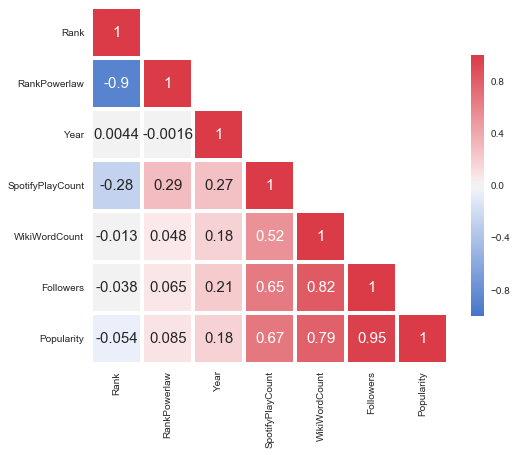

In [105]:
sns.set(style="white")
corr = df_music5.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

In [106]:
feature_list = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity']
target_list  = ['SpotifyPlayCount']

feature = df_music5.loc[:, feature_list]
target  = df_music5.loc[:, target_list]

In [107]:
lr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


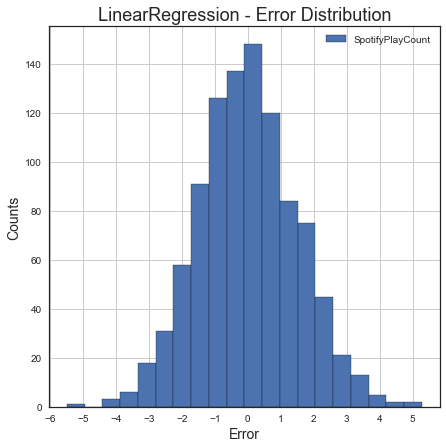

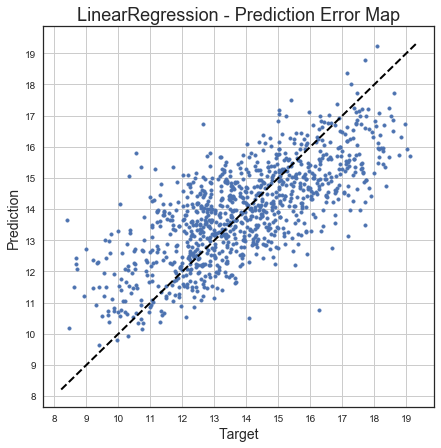

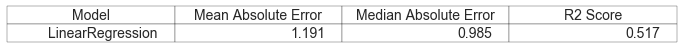

In [108]:
evaluation(lr, feature, target)

In [109]:
'''
for i in range(0, 986):
#for i in range(0, 2):
    print(i)
    song5   = df_music5.iloc[i, :]      # song in dataset-12-5
    artist5 = song5.Artist
    title5  = song5.Title
    genre5  = song5.Genre
    
    for j in range(0, 986):
        song4   = df_music4.iloc[j, :]  # song in dataset-12-4
        artist4 = song4.Artist
        title4  = song4.Title
        genre4  = song4.Genre
        
        if artist5 == artist4 and title5 == title4:
            song4.Genre = genre5
            df_music4.iloc[j,:] = song4
            continue
'''

'\nfor i in range(0, 986):\n#for i in range(0, 2):\n    print(i)\n    song5   = df_music5.iloc[i, :]      # song in dataset-12-5\n    artist5 = song5.Artist\n    title5  = song5.Title\n    genre5  = song5.Genre\n    \n    for j in range(0, 986):\n        song4   = df_music4.iloc[j, :]  # song in dataset-12-4\n        artist4 = song4.Artist\n        title4  = song4.Title\n        genre4  = song4.Genre\n        \n        if artist5 == artist4 and title5 == title4:\n            song4.Genre = genre5\n            df_music4.iloc[j,:] = song4\n            continue\n'

# Test the Genres

In [117]:
dummy_genre = pd.get_dummies(df_music5.Genre)

In [118]:
dummy_genre.head()

,beat,country,easyListening,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [119]:
df_musicf = df_music5.join(dummy_genre, how='outer')

In [122]:
df_musicf.to_csv('../music_data/dateset-12-5-test.csv', index=False)

In [123]:
do_log(df_musicf,feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount', 'Followers'])
z_score_norm(df_musicf, feature_list=['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity'])

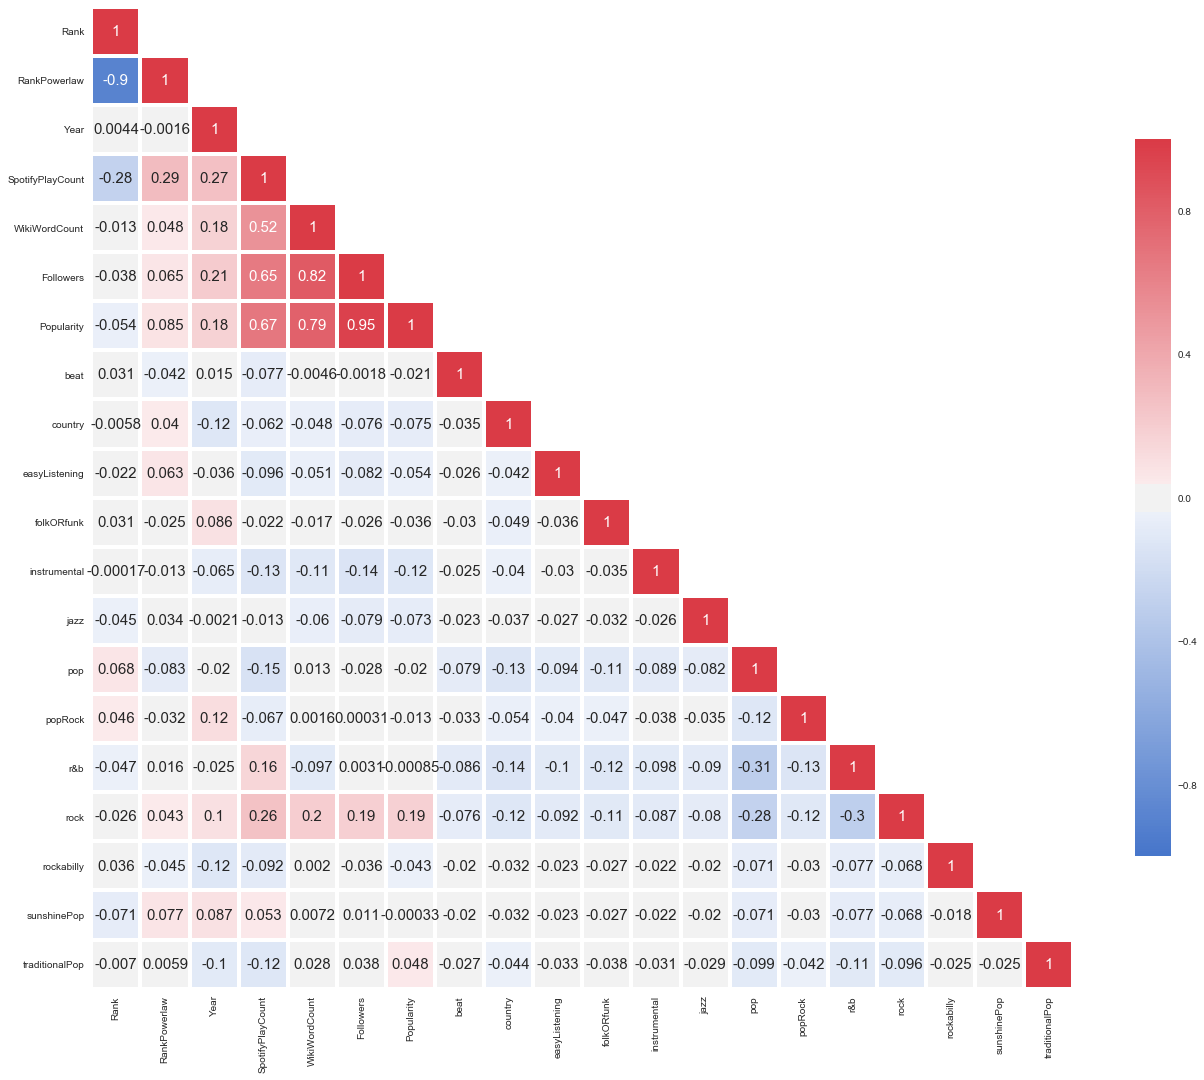

In [127]:
sns.set(style="white")
corr = df_musicf.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(22, 22))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

In [128]:
df_musicf.columns

Index(['Rank', 'RankPowerlaw', 'Artist', 'Title', 'Year', 'SpotifyPlayCount',
       'WikiWordCount', 'Followers', 'Popularity', 'Genre', 'beat', 'country',
       'easyListening', 'folkORfunk', 'instrumental', 'jazz', 'pop', 'popRock',
       'r&b', 'rock', 'rockabilly', 'sunshinePop', 'traditionalPop'],
      dtype='object')

This is the plots/reports of LinearRegression


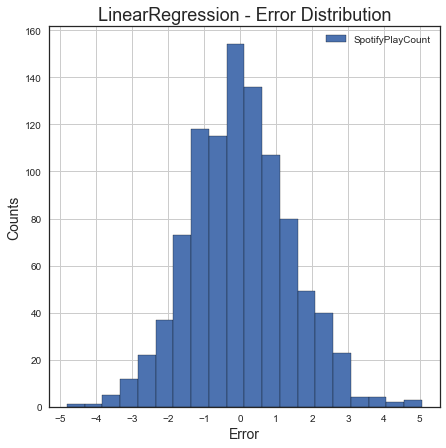

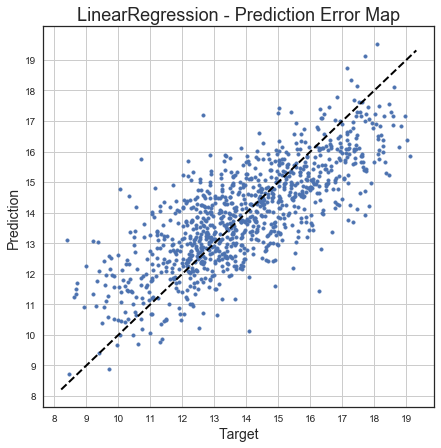

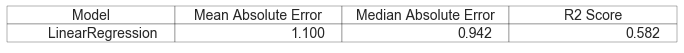

In [133]:
feature_list1 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 'beat', 'country', 
                'folkORfunk', 'instrumental', 'jazz', 'pop', 'popRock', 'r&b', 'rock', 'rockabilly', 'sunshinePop', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list1]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

This is the plots/reports of LinearRegression


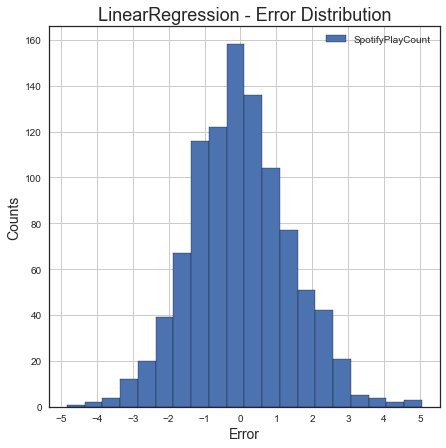

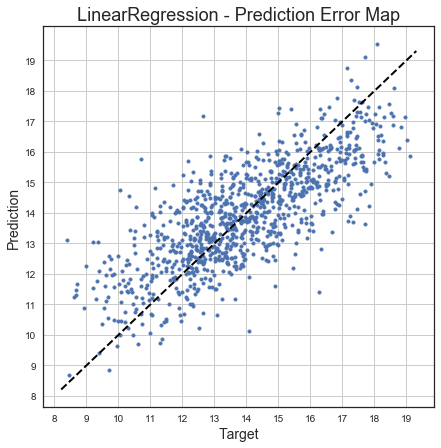

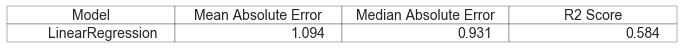

In [146]:
feature_list2 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 
                 'beat', 'easyListening', 'instrumental', 'pop', 'popRock', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list2]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

This is the plots/reports of LinearRegression


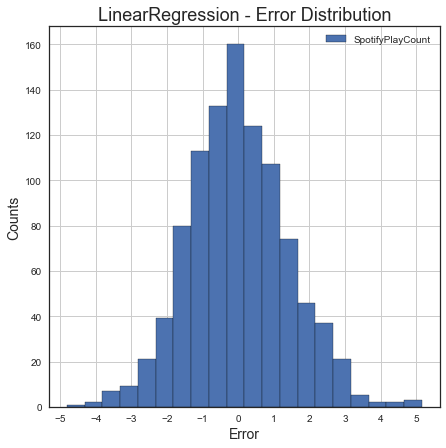

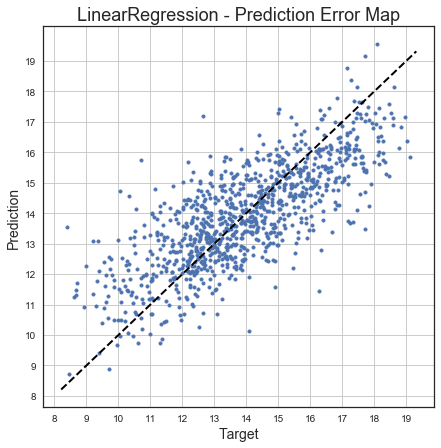

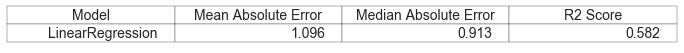

In [147]:
feature_list3 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 
                 'beat', 'easyListening', 'instrumental', 'pop', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list2]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)